In [1]:
import sys
import joblib
import os
import scipy.io as sio
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import cmocean as cm

In [2]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.cnn import CNN_AE
from src.inputs import GaussianInputs
from src.optimizer import GPOptimizer, DeepGPOptimizer
from src.utils import *

In [3]:
project = 'kolmogorov'

latent_dim = 20
tstep = 16710
tstep = 9407

In [4]:
L1, L2 = 2*np.pi, 2*np.pi
n1, n2 = 64, 64

grid_x = np.linspace(0,L1-L1/n1,n1)
grid_y = np.linspace(0,L2-L2/n2,n2)

grid_x, grid_y = np.meshgrid(grid_x, grid_y)

Kx = np.concatenate([np.arange(0, n1//2), np.arange(-n1//2, 0)]) * (2 * np.pi / L1)
Ky = np.concatenate([np.arange(0, n2//2), np.arange(-n2//2, 0)]) * (2 * np.pi / L2)

kx, ky = np.meshgrid(Kx,Ky)

dt_sim = 0.5
T_sim = 10000
nt = int(T_sim/dt_sim)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
u = np.load(f'{project_root}/data/{project}/u1.npy')
v = np.load(f'{project_root}/data/{project}/u2.npy')
w = np.load(f'{project_root}/data/{project}/vorticity.npy')

In [6]:
np.random.seed(5)

dt = 0.1
T = 1.5
dts = [dt for _ in range(int(T / dt))]

num_traj = 3
trajectories = {}

# Select three (x0, y0) points that form a triangle on the 2D grid
selected = []
# Use three well-separated corners of the grid to form a triangle
# point_indices = [(20, 45), (47, n1//2), (20, 20)]
point_indices = [(45, 17), (n1//2, 47), (18, 17)]
# point_indices = [(45, 17), (42, 60), (18, 17)]

for xi, yi in point_indices:
    selected.append([grid_x[xi, yi], grid_y[xi, yi]])

for traj_i, (x0, y0) in enumerate(selected):
    traj = generate_trajectory(u[tstep, :, :], v[tstep, :, :], grid_x, grid_y, x0, y0, dts)
    trajectories[traj_i] = traj


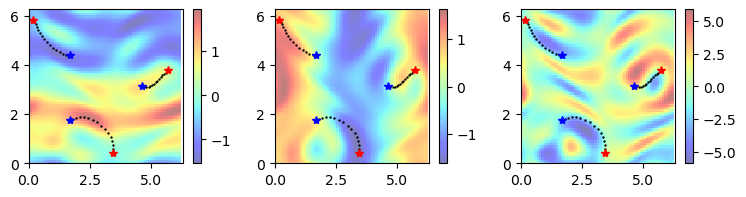

In [7]:
plt.figure(figsize=(9,2))

for i in range(3):
    if i == 0:
        plot_data = u[tstep,:,:]
    elif i == 1:
        plot_data = v[tstep,:,:]
    elif i == 2:
        plot_data = w[tstep,:,:]
        
    ax = plt.subplot(1,3,i+1)
    c = plot_trajectories(ax, plot_data, grid_x, grid_y, trajectories, 0, L1, 0, L2, cmap='jet')
    plt.colorbar(c)

In [8]:
ae = CNN_AE(latent_dim=latent_dim)

ae.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_model.pth'))
ae.to(device)
D = ae.decode

data, ae_scaler = transform_data_for_AE(u,v)
latent_space = get_latent_space(ae, data)

latent_distribution = gaussian_kde(latent_space)

In [9]:
acquisition_function = 'LCB'
optimizer = GPOptimizer(trajectories, dts, trajectory_cost_function, D, latent_distribution, grid_x, grid_y, ae_scaler, device, acquisition_function)

 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning:Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1719512383855/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)


In [10]:
load_from_existing = False
save_data = False

if load_from_existing:
    optimizer.X = np.load(f'{project_root}/results/{project}/bo/X_{tstep}_{acquisition_function}.npy')
    optimizer.Y = np.load(f'{project_root}/results/{project}/bo/Y_{tstep}_{acquisition_function}.npy')
    optimizer.scaler_gp_x = joblib.load(f'{project_root}/results/{project}/bo/scaler_gp_x_{tstep}_{acquisition_function}.joblib')
    optimizer.scaler_gp_y = joblib.load(f'{project_root}/results/{project}/bo/scaler_gp_y_{tstep}_{acquisition_function}.joblib')
else:
    optimizer.optimize(n_iterations=150)
    if save_data:
        np.save(f'{project_root}/results/{project}/bo/X_{tstep}.npy', optimizer.X)
        np.save(f'{project_root}/results/{project}/bo/Y_{tstep}.npy', optimizer.Y)
        joblib.dump(optimizer.scaler_gp_x, f'{project_root}/results/{project}/bo/scaler_gp_x_{tstep}_{acquisition_function}.joblib');
        joblib.dump(optimizer.scaler_gp_y, f'{project_root}/results/{project}/bo/scaler_gp_y_{tstep}_{acquisition_function}.joblib');

 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Iteration 0: 44.61146565488662


 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Iteration 2: 35.49785355970441


 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Iteration 3: 34.226086562186396


 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Iteration 7: 27.940624802915753


 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered i

Iteration 29: 25.680839743279577


 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered i

Iteration 92: 21.742640569662985


 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Iteration 93: 5.268295941688937


 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered i

In [11]:
z_opt, u_opt, v_opt, traj_opt = optimizer.get_optimal()
w_opt = vort(u_opt, v_opt, kx, ky)

In [40]:
costs = optimizer.scaler_gp_y.inverse_transform(optimizer.Y)
costs_sorted = np.sort(costs, axis=0)

k = len(np.argwhere(costs - costs_sorted[0] < 3))
print(k)

k = 5
z_top, u_top, v_top, traj_top = optimizer.get_top_k(k)
w_top = np.array([vort(ui, vi, kx, ky) for ui, vi in zip(u_top, v_top)])

u_mean = np.mean(u_top, axis=0)
v_mean = np.mean(v_top, axis=0)
w_mean = np.mean(w_top, axis=0)

1


In [13]:
u_plot = u[tstep, :, :]
v_plot = v[tstep, :, :]
w_plot = w[tstep, :, :]

In [14]:
def pattern_corr(a, b):
    # Flatten spatial dimensions, compute centered pattern correlation
    a_flat = a.reshape(a.shape[0], -1)
    b_flat = b.reshape(b.shape[0], -1)
    # Remove mean over spatial dimensions
    a_centered = a_flat - a_flat.mean(axis=1, keepdims=True)
    b_centered = b_flat - b_flat.mean(axis=1, keepdims=True)
    # Compute correlation for each sample
    num = np.sum(a_centered * b_centered, axis=1)
    denom = np.sqrt(np.sum(a_centered**2, axis=1) * np.sum(b_centered**2, axis=1))
    return num / denom

corr_opt = pattern_corr(w_plot, w_opt)
corr_mean = pattern_corr(w_plot, w_mean)
print(f'Pattern correlation with optimal: {corr_opt.mean():.3f}')
print(f'Pattern correlation with mean: {corr_mean.mean():.3f}')

Pattern correlation with optimal: 0.603
Pattern correlation with mean: 0.181


In [15]:
file_name = file_naming(point_indices, latent_dim, tstep)

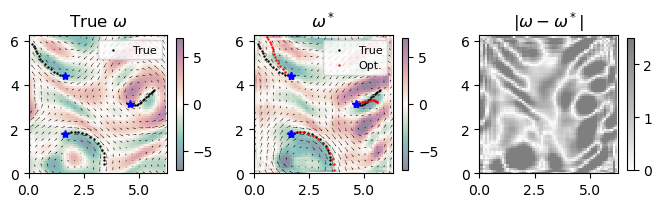

In [32]:
fig = plt.figure(figsize=(6.75, 1.875))

plot_configs = [
    dict(data=w_plot, traj=trajectories, cmap=cm.cm.curl, vmin=-7, vmax=7, title='True $\omega$', quiver_u=u_plot, quiver_v=v_plot, plot_top=False),
    dict(data=w_opt, traj=traj_opt, cmap=cm.cm.curl, vmin=-7, vmax=7, title=f'$\omega^*$', quiver_u=u_opt, quiver_v=v_opt, plot_top=False),
    dict(data=np.abs(w_plot-w_opt), traj=[], cmap=cm.cm.gray_r, vmin=0, vmax=2.5, title='$|\omega - \omega^*$|', quiver_u=None, quiver_v=None, plot_top=False),
]

for i, cfg in enumerate(plot_configs):
    ax = plt.subplot(1, 3, i+1)
    c = plot_field(ax, cfg['data'], grid_x, grid_y, 0, L1, 0, L2, cfg['vmin'], cfg['vmax'], cfg['cmap'])
    plt.colorbar(c, shrink=0.95)
    plt.title(cfg['title'])

    if cfg['quiver_u'] is not None and cfg['quiver_v'] is not None:
        plt.quiver(grid_x[::3,::3], grid_y[::3,::3], cfg['quiver_u'][::3,::3], cfg['quiver_v'][::3,::3], color='k')

    if i == 0:
        plot_trajectories_lines(cfg['traj'], color='k', label='True')
        plt.legend(loc='upper right', fontsize=8)

    if i == 1:
        plot_trajectories_lines(trajectories, color='k', label='True')
        plot_trajectories_lines(traj_opt, color='red', label='Opt.')
        plt.legend(loc='upper right', fontsize=8)

plt.tight_layout(pad=0.75)
plt.savefig(f'{project_root}/figures/{project}/bo/kolm_traj_opt_{file_name}_vorticity.png', dpi=300, bbox_inches='tight')


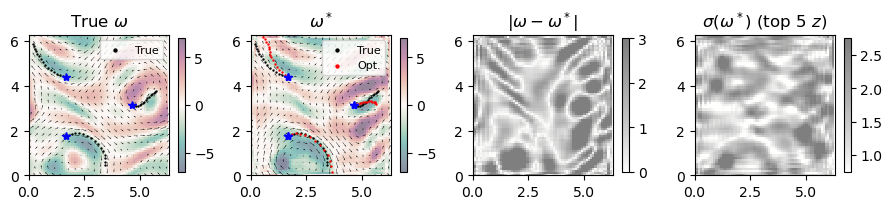

In [47]:
fig = plt.figure(figsize=(9, 1.875))

plot_configs = [
    dict(data=w_plot, traj=trajectories, cmap=cm.cm.curl, vmin=-7, vmax=7, title='True $\omega$', quiver_u=u_plot, quiver_v=v_plot, plot_top=False),
    dict(data=w_opt, traj=traj_opt, cmap=cm.cm.curl, vmin=-7, vmax=7, title=f'$\omega^*$', quiver_u=u_opt, quiver_v=v_opt, plot_top=False),
    dict(data=np.abs(w_plot-w_opt), traj=[], cmap=cm.cm.gray_r, vmin=0, vmax=3, title='$|\omega - \omega^*|$', quiver_u=None, quiver_v=None, plot_top=False),
    dict(data=np.std(w_top, axis=0), traj=[], cmap=cm.cm.gray_r, vmin=0.75, vmax=2.75, title=f'$\sigma(\omega^*)$ (top {k} $z$)', quiver_u=None, quiver_v=None, plot_top=False),
]

for i, cfg in enumerate(plot_configs):
    ax = plt.subplot(1, 4, i+1)
    c = plot_field(ax, cfg['data'], grid_x, grid_y, 0, L1, 0, L2, cfg['vmin'], cfg['vmax'], cfg['cmap'])
    plt.colorbar(c, shrink=0.95)
    plt.title(cfg['title'])

    if cfg['quiver_u'] is not None and cfg['quiver_v'] is not None:
        plt.quiver(grid_x[::3,::3], grid_y[::3,::3], cfg['quiver_u'][::3,::3], cfg['quiver_v'][::3,::3], color='k')

    if i == 0:
        plot_trajectories_lines(cfg['traj'], color='k', label='True')
        plt.legend(loc='upper right', fontsize=8, markerscale=3)

    if i == 1:
        plot_trajectories_lines(trajectories, color='k', label='True')
        plot_trajectories_lines(traj_opt, color='red', label='Opt.')
        plt.legend(loc='upper right', fontsize=8, markerscale=3)

plt.tight_layout(pad=0.75)
plt.savefig(f'{project_root}/figures/{project}/bo/kolm_traj_opt_{file_name}_vorticity_std_top_{k}.png', dpi=300, bbox_inches='tight')


In [42]:
print(f'Pattern correlation std and error: {pattern_corr(np.std(w_top, axis=0), np.abs(w_plot - w_opt)).mean()}')

Pattern correlation std and error: 0.32507769447298374


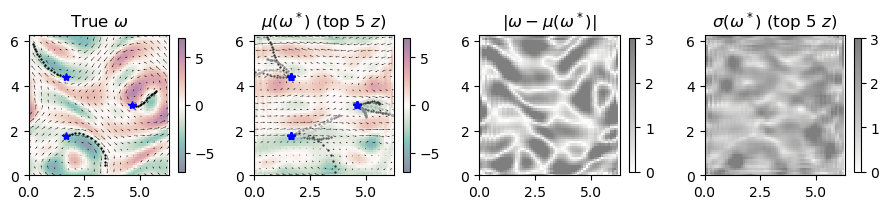

In [48]:
fig = plt.figure(figsize=(9, 1.875))

plot_configs = [
    dict(data=w_plot, traj=trajectories, cmap=cm.cm.curl, vmin=-7, vmax=7, title='True $\omega$', quiver_u=u_plot, quiver_v=v_plot, plot_top=False),
    dict(data=w_mean, traj=traj_opt, cmap=cm.cm.curl, vmin=-7, vmax=7, title=f'$\mu(\omega^*)$ (top {k} $z$)', quiver_u=u_mean, quiver_v=v_mean, plot_top=True),
    dict(data=np.abs(w_plot-w_mean), traj=[], cmap=cm.cm.gray_r, vmin=0, vmax=3, title='$|\omega - \mu(\omega^*)|$', quiver_u=None, quiver_v=None, plot_top=False),
    dict(data=np.std(w_top, axis=0), traj=[], cmap=cm.cm.gray_r, vmin=0, vmax=3, title=f'$\sigma(\omega^*)$ (top {k} $z$)', quiver_u=None, quiver_v=None, plot_top=False),
]

for i, cfg in enumerate(plot_configs):
    ax = plt.subplot(1, 4, i+1)
    c = plot_field(ax, cfg['data'], grid_x, grid_y, 0, L1, 0, L2, cfg['vmin'], cfg['vmax'], cfg['cmap'])
    plt.colorbar(c, shrink=0.95)
    plt.title(cfg['title'])

    if cfg['quiver_u'] is not None and cfg['quiver_v'] is not None:
        plt.quiver(grid_x[::3,::3], grid_y[::3,::3], cfg['quiver_u'][::3,::3], cfg['quiver_v'][::3,::3], color='k')

    if i == 0:
        plot_trajectories_lines(cfg['traj'])

    if cfg['plot_top']:
        for j in range(len(traj_top)):
            plot_trajectories_lines(traj_top[j], color=str(0.2 + 0.16 * j))

plt.tight_layout(pad=0.75)
plt.savefig(f'{project_root}/figures/{project}/bo/kolm_traj_opt_top_{k}_{file_name}_vorticity.png', dpi=300, bbox_inches='tight')


In [20]:


# plot_configs = [
#     {"data": u_plot, "traj": trajectories, "cmap": "jet", "vmin": u_plot.min(), "vmax": u_plot.max(), "title": "True $u$"},
#     {"data": v_plot, "traj": trajectories, "cmap": "jet", "vmin": v_plot.min(), "vmax": v_plot.max(), "title": "True $v$"},
#     {"data": w_plot, "traj": trajectories, "cmap": "jet", "vmin": -7, "vmax": 7, "title": "True $\omega$"},
#     {"data": u_opt, "traj": traj_opt, "cmap": "jet", "vmin": u_plot.min(), "vmax": u_plot.max(), "title": "Optimized $u*$"},
#     {"data": v_opt, "traj": traj_opt, "cmap": "jet", "vmin": v_plot.min(), "vmax": v_plot.max(), "title": "Optimized $v*$"},
#     {"data": w_opt, "traj": traj_opt, "cmap": "jet", "vmin": -7, "vmax": 7, "title": "Optimized $\omega *$"},
#     {"data": u_plot-u_opt, "traj": [], "cmap": "coolwarm", "vmin": -0.5, "vmax": 0.5, "title": "$u - u*$"},
#     {"data": v_plot-v_opt, "traj": [], "cmap": "coolwarm", "vmin": -1, "vmax": 1, "title": "$v - v*$"},
#     {"data": w_plot-w_opt, "traj": [], "cmap": "coolwarm", "vmin": -3, "vmax": 3, "title": "$\omega - \omega*$"},
# ]

# fig = plt.figure(figsize=(7,6))

# for i, cfg in enumerate(plot_configs):
#     ax = plt.subplot(3, 3, i+1)
#     c = plot_trajectories(ax, cfg["data"], grid_x, grid_y, cfg["traj"], 0, L1, 0, L2, cfg["vmin"], cfg["vmax"], cfg["cmap"])
#     if i == 0:
#         plt.legend(handlelength=1, handletextpad=0.1)
#     if i == 2:
#         plt.quiver(grid_x[::3,::3], grid_y[::3,::3], u_plot[::3,::3], v_plot[::3,::3], color='k')
#     if i == 5:
#         plt.quiver(grid_x[::3,::3], grid_y[::3,::3], u_opt[::3,::3], v_opt[::3,::3], color='k')
#     plt.colorbar(c, shrink=0.95)
#     plt.title(cfg["title"])

# plt.tight_layout(pad=0.75)
# plt.savefig(f'{project_root}/figures/{project}/bo/kolm_traj_opt_{file_name}.png', dpi=300, bbox_inches='tight')


In [21]:
# fig = plt.figure(figsize=(7,8))

# plot_configs = [
#     # i, data, traj, cmap, vmin, vmax, title, quiver_u, quiver_v, plot_top
#     dict(data=u_plot, traj=trajectories, cmap='jet', vmin=u_plot.min(), vmax=u_plot.max(), title='True $u$', quiver_u=u_plot, quiver_v=v_plot, plot_top=False),
#     dict(data=v_plot, traj=trajectories, cmap='jet', vmin=v_plot.min(), vmax=v_plot.max(), title='True $v$', quiver_u=None, quiver_v=None, plot_top=False),
#     dict(data=w_plot, traj=trajectories, cmap='jet', vmin=-7, vmax=7, title='True $\omega$', quiver_u=u_plot, quiver_v=v_plot, plot_top=False),
#     dict(data=u_mean, traj=traj_opt, cmap='jet', vmin=u_plot.min(), vmax=u_plot.max(), title=f'$\mu(u^*)$ (top {k} $z$)', quiver_u=u_mean, quiver_v=v_mean, plot_top=True),
#     dict(data=v_mean, traj=traj_opt, cmap='jet', vmin=v_plot.min(), vmax=v_plot.max(), title=f'$\mu(v^*)$ (top {k} $z$)', quiver_u=None, quiver_v=None, plot_top=True),
#     dict(data=w_mean, traj=traj_opt, cmap='jet', vmin=-7, vmax=7, title=f'$\mu(\omega^*)$ (top {k} $z$)', quiver_u=w_mean, quiver_v=None, plot_top=True),
#     dict(data=u_plot-u_mean, traj=[], cmap='coolwarm', vmin=-0.5, vmax=0.5, title='$u - \mu(u*)$', quiver_u=None, quiver_v=None, plot_top=False),
#     dict(data=v_plot-v_mean, traj=[], cmap='coolwarm', vmin=-1, vmax=1, title='$v - \mu(v*)$', quiver_u=None, quiver_v=None, plot_top=False),
#     dict(data=w_plot-w_mean, traj=[], cmap='coolwarm', vmin=-3, vmax=3, title='$\omega - \mu(\omega *)$', quiver_u=None, quiver_v=None, plot_top=False),
#     dict(data=np.std(u_top, axis=0), traj=[], cmap='coolwarm', vmin=0, vmax=1, title=f'$\sigma(u^*)$ (top {k} $z$)', quiver_u=None, quiver_v=None, plot_top=False),
#     dict(data=np.std(v_top, axis=0), traj=[], cmap='coolwarm', vmin=0, vmax=1, title=f'$\sigma(v^*)$ (top {k} $z$)', quiver_u=None, quiver_v=None, plot_top=False),
#     dict(data=np.std(w_top, axis=0), traj=[], cmap='coolwarm', vmin=0, vmax=3, title=f'$\sigma(\omega^*)$ (top {k} $z$)', quiver_u=None, quiver_v=None, plot_top=False),
# ]

# for i, cfg in enumerate(plot_configs):
#     ax = plt.subplot(4, 3, i+1)
#     c = plot_field(ax, cfg['data'], grid_x, grid_y, 0, L1, 0, L2, cfg['vmin'], cfg['vmax'], cfg['cmap'])
#     plt.colorbar(c, shrink=0.95)
#     plt.title(cfg['title'])

#     if cfg['quiver_u'] is not None and cfg['quiver_v'] is not None:
#         plt.quiver(grid_x[::3,::3], grid_y[::3,::3], cfg['quiver_u'][::3,::3], cfg['quiver_v'][::3,::3], color='k')

#     if i in [0, 1, 2]:
#         plot_trajectories_lines(cfg['traj'])

#     if cfg['plot_top']:
#         for j in range(len(traj_top)):
#             plot_trajectories_lines(traj_top[j], color=str(0.2 + 0.16 * j))

# plt.tight_layout(pad=0.75) 
# plt.savefig(f'{project_root}/figures/{project}/bo/kolm_traj_opt_top_{k}_{file_name}.png', dpi=300, bbox_inches='tight')
